### Introduction

The goal of this notebook is to build from scratch a neural network for an image classficiation task.

This is to have a good grasp of deep learning concepts ..

## Plan

**1-** Prepare the dataset

**2-** Implementing the forward pass

**3-** Implementing the backwad pass

**4-** Evaluating the performance of the nn

**5-** Experiments with the nn parametres and how they affect the performances 

Some questions that we want to answer are : 

* Can we find some correlation between the variance in the dataset and the size of the neural network? 
* Is the bias part of the neurons important in the task?
* Does the activation function affects the value to be choosen for the learning rate

## 1-  Loading the dataset

In [26]:
import tensorflow as tf

# Load the MNIST dataset                                
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Shuffle the training data
indices = tf.range(start=0, limit=tf.shape(x_train)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

x_train = tf.gather(x_train, shuffled_indices)
y_train = tf.gather(y_train, shuffled_indices)

# Convert tensors back to numpy arrays
x_train = x_train.numpy()
y_train = y_train.numpy()

# Display the shape of the loaded data
print("Training data shape:", x_train.shape)  # (60000, 28, 28)
print("Training labels shape:", y_train.shape)  # (60000,)
print("Test data shape:", x_test.shape)  # (10000, 28, 28)
print("Test labels shape:", y_test.shape)  # (10000,)

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


##  2-  Visualizing the dataset

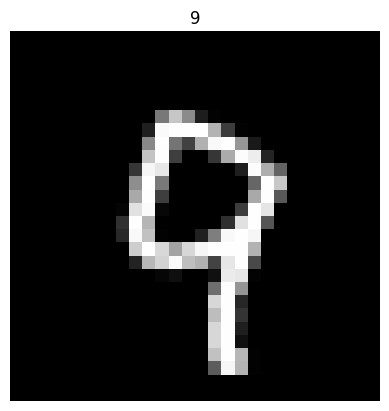

In [27]:
import matplotlib.pyplot as plt
import numpy as np

random_idx = np.random.randint(1000)

image = x_train[random_idx]
label = y_train[random_idx]


def visualize_image(image, label):
    plt.imshow(image, cmap='gray')  # Display the image
    plt.axis('off')  # Turn off the axes
    plt.title(label)
    plt.show()  # Show the image
    
visualize_image(image, label)

==> Each image is a **28*28** pixels, which gives a list of **784** elements

## 3- Implementing the forward pass

Our neural network, would be such that there is only one hidden layer with **300** neurons, and the output layer with **10**neurons

For now, the activations functions would be all linear, and in to generate the output we take the argmax.

Our loss function will be the Mean Squared Error, aka **MSE**

In [28]:
input_layer = image.flatten()

In [29]:
## Initializing the weights linking the input layer with the hidden layer

size_input_layer = len(input_layer) #784
size_hidden_layer = 300
size_output_layer = 10
print(len(input_layer))

def init_weights():
    weight_input_hidden = np.random.random((size_input_layer, size_hidden_layer))
    weight_hidden_output = np.random.random((size_hidden_layer, size_output_layer))
    
    return weight_input_hidden, weight_hidden_output

weight_input_hidden, weight_hidden_output = init_weights()
weights = weight_input_hidden, weight_hidden_output

784


In [59]:
def init_weights_he():
    # He initialization for weight_input_hidden
    limit_input_hidden = np.sqrt(2 / size_input_layer)
    weight_input_hidden = np.random.randn(size_input_layer, size_hidden_layer) * limit_input_hidden
    
    # He initialization for weight_hidden_output
    limit_hidden_output = np.sqrt(2 / size_hidden_layer)
    weight_hidden_output = np.random.randn(size_hidden_layer, size_output_layer) * limit_hidden_output
    
    return weight_input_hidden, weight_hidden_output


In [30]:
def init_weights_xavier():
    # Xavier initialization for weight_input_hidden
    limit_input_hidden = np.sqrt(6 / (size_input_layer + size_hidden_layer))
    weight_input_hidden = np.random.uniform(-limit_input_hidden, limit_input_hidden, 
                                            (size_input_layer, size_hidden_layer))
    
    # Xavier initialization for weight_hidden_output
    limit_hidden_output = np.sqrt(6 / (size_hidden_layer + size_output_layer))
    weight_hidden_output = np.random.uniform(-limit_hidden_output, limit_hidden_output, 
                                             (size_hidden_layer, size_output_layer))
    
    return weight_input_hidden, weight_hidden_output

# Test the initialization
weights_xavier = init_weights_xavier()
weights_xavier[0].shape, weights_xavier[1].shape  # Just to check if the shapes are correct


((784, 300), (300, 10))

In [31]:
# Hidden layer result
hidden_representation = np.dot(input_layer, weight_input_hidden)

# Min max normalization
mi = hidden_representation.min()
ma = hidden_representation.max()

# min max normalization
norm_hidden_representation = (hidden_representation - mi)/(ma-mi)

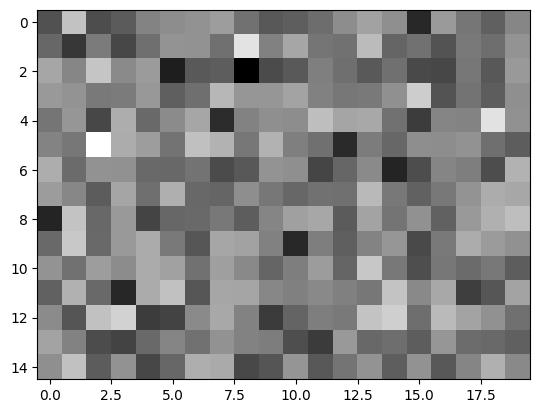

In [32]:
plt.imshow(norm_hidden_representation.reshape(15,20), cmap='gray')  # Display the image

In [33]:
## hidden output result 

ouput_result = np.dot(norm_hidden_representation, weight_hidden_output)
ouput_result.shape

(10,)

In [34]:
# Result of the forward pass
ouput_result.argmax()

1

In [35]:
# Defining the function that takes as an input the input layer(vector) and parameters and returns the predicted written number
def predict_number(input_layer, weights):
    size_input_layer = len(input_layer) #784
    size_hidden_layer = 300
    size_output_layer = 10
    
    weights = weight_input_hidden, weight_hidden_output

    hidden_representation = np.dot(input_layer, weight_input_hidden)
    mi = hidden_representation.min()
    ma = hidden_representation.max()

    # min max normalization
    norm_hidden_representation = (hidden_representation - mi)/(ma-mi)

    ouput_result = np.dot(norm_hidden_representation, weight_hidden_output)
    # Result of the forward pass
    result = ouput_result.argmax()
    return result


In [243]:
# Defining the function that takes as an input the input layer(vector) and parameters and returns the hidden representation and the output result
def forward_pass(input_layer, weights):
    
    weight_input_hidden, weight_hidden_output = weights
    
    hidden_representation = np.dot(input_layer, weight_input_hidden)
    
    mean = np.mean(hidden_representation)
    variance = np.var(hidden_representation)
    epsilon = 10 **(-5)
    scaled_hidden_representation = (hidden_representation - mean)/np.sqrt(variance + epsilon)

    output_result = np.dot(scaled_hidden_representation, weight_hidden_output)
    
    return scaled_hidden_representation, output_result

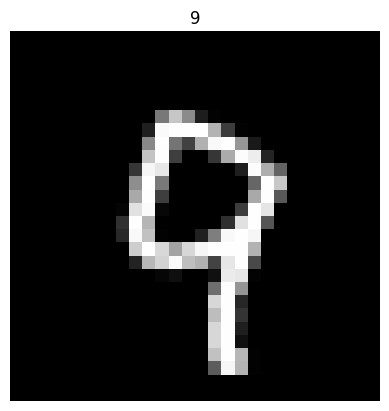

(300,)

In [37]:
#Test
visualize_image(image, label)
forward_pass(input_layer, weights)[0].shape

## 4- Implementing the backward pass:

This section would modify the *input_hidden_weights* and *hidden_output_weights* in order to make better predictions.

The weights modifications would be based on the backpropagation algorithms

In [38]:
def MSE(predicted, desired):
    # This function takes as input numpy arrays and not lists
    diff = 1/2 * ((predicted - desired)**2).sum()
    return diff

In [39]:
def full_backward_pass(weights, image, label, lr = 0.01, lamda = 0.01):
    # We only modify the weights between the last and the penultimate layer
    # weights is a tuple of matrices : weight_input_hidden & weight_hidden_output

    size_hidden_layer = 300
    size_output_layer = 10

    # one hot encoding the label
    desired = np.zeros(size_output_layer)
    desired[int(label)] = 1

    weight_input_hidden, weight_hidden_output = weights
    new_weight_input_hidden, new_weight_hidden_output = weight_input_hidden.copy(), weight_hidden_output.copy()

    input_layer = image.flatten() # flattening the image

    hidden_representation, output_result = forward_pass(input_layer, (weight_input_hidden, weight_hidden_output)) # forward pass

    output_result =  tf.nn.softmax(output_result) # softmax operation

    delta_matrix = np.zeros((size_hidden_layer, size_output_layer))

    # gradient descent iteration # backward pass for the second layer
    for k in range(size_output_layer):
        for j in range(size_hidden_layer):
            delta = (output_result[k] - desired[k]) * hidden_representation[j] * (1 - output_result[k]) * output_result[k]
            new_weight_hidden_output[j][k] = (1-lamda) * new_weight_hidden_output[j][k] - lr*delta

            delta_matrix[j][k] = delta

    for j in range(size_hidden_layer):
        for i in range(size_input_layer):
            delta = np.sum(new_weight_hidden_output[j]* (delta_matrix[j]) * input_layer[i] / hidden_representation[j])
            new_weight_input_hidden[i][j] = (1-lamda) * new_weight_input_hidden[i][j] - lr*delta


    return new_weight_input_hidden, new_weight_hidden_output

In [63]:
def full_backward_pass_cross_entropy(weights, image, label, lr=0.01, lamda=0.01):
    size_hidden_layer = 300
    size_output_layer = 10

    # one hot encoding the label
    desired = np.zeros(size_output_layer)
    desired[int(label)] = 1

    weight_input_hidden, weight_hidden_output = weights
    new_weight_input_hidden, new_weight_hidden_output = weight_input_hidden.copy(), weight_hidden_output.copy()

    input_layer = image.flatten()  # flattening the image

    hidden_representation, logits = forward_pass(input_layer, (weight_input_hidden, weight_hidden_output))  # forward pass
    output_result = tf.nn.softmax(logits)  # softmax operation

    # Gradient of cross-entropy loss w.r.t. logits
    d_logits = output_result - desired

    # Backward pass for the second layer
    d_weight_hidden_output = np.outer(hidden_representation, d_logits)
    new_weight_hidden_output = (1 - lamda) * weight_hidden_output - lr * d_weight_hidden_output

    # Backward pass for the first layer
    d_hidden_representation = np.dot(d_logits, weight_hidden_output.T)
    d_weight_input_hidden = np.outer(input_layer, d_hidden_representation)
    new_weight_input_hidden = (1 - lamda) * weight_input_hidden - lr * d_weight_input_hidden

    return new_weight_input_hidden, new_weight_hidden_output

In [245]:
def full_backward_pass_cross_entropy_adam(weights, image, label, t, m_prev_1, m_prev_2, v_prev_1, v_prev_2, lr=0.001, lamda=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    size_hidden_layer = 300
    size_output_layer = 10

    # one hot encoding the label
    desired = np.zeros(size_output_layer)
    desired[int(label)] = 1

    weight_input_hidden, weight_hidden_output = weights

    input_layer = image.flatten()  # flattening the image
    hidden_representation, logits = forward_pass(input_layer, (weight_input_hidden, weight_hidden_output))  # forward pass
    output_result = tf.nn.softmax(logits)  # softmax operation

    # Gradient of cross-entropy loss w.r.t. logits
    d_logits = output_result - desired

    # Backward pass for the second layer
    d_weight_hidden_output = np.outer(hidden_representation, d_logits)
    # Adam for weight_hidden_output
    m_t_2 = beta1 * m_prev_2 + (1 - beta1) * d_weight_hidden_output
    v_t_2 = beta2 * v_prev_2 + (1 - beta2) * d_weight_hidden_output**2
    m_t_hat_2 = m_t_2 / (1 - beta1**t)
    v_t_hat_2 = v_t_2 / (1 - beta2**t)
    new_weight_hidden_output = weight_hidden_output - lr * m_t_hat_2 / (np.sqrt(v_t_hat_2) + epsilon)

    # Backward pass for the first layer
    d_hidden_representation = np.dot(d_logits, weight_hidden_output.T)
    d_weight_input_hidden = np.outer(input_layer, d_hidden_representation)
    # Adam for weight_input_hidden
    m_t_1 = beta1 * m_prev_1 + (1 - beta1) * d_weight_input_hidden
    v_t_1 = beta2 * v_prev_1 + (1 - beta2) * d_weight_input_hidden**2
    m_t_hat_1 = m_t_1 / (1 - beta1**t)
    v_t_hat_1 = v_t_1 / (1 - beta2**t)
    new_weight_input_hidden = weight_input_hidden - lr * m_t_hat_1 / (np.sqrt(v_t_hat_1) + epsilon)

    return new_weight_input_hidden, new_weight_hidden_output, m_t_1, m_t_2, v_t_1, v_t_2

# Note: This function now also returns the updated moments m and v for both layers, which should be passed in the next call for updates.


In [40]:
# testing the backward pass 

# preparing the args
random_idx += 1 

image = x_train[random_idx]; input_layer = image.flatten()
label = y_train[random_idx]

# one hot encoding
desired = np.zeros(size_output_layer)
desired[int(label)] = 1

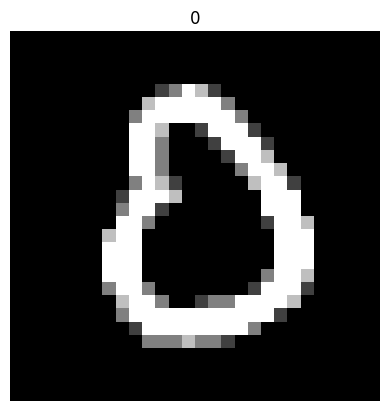

In [41]:
visualize_image(image, label)

In [42]:
# skip if you don't want to perform the backward pass
new_weight_input_hidden, new_weight_hidden_output = full_backward_pass(weights, image, label)

In [43]:
_, new_output = forward_pass(input_layer, (new_weight_input_hidden, new_weight_hidden_output))
norm_new_output = np.array(tf.nn.softmax(new_output)) # transforming the logits to probs
MSE(norm_new_output, desired)

9.332933829895338e-36

In [44]:
_, old_output = forward_pass(input_layer, (weight_input_hidden, weight_hidden_output))
norm_old_output = np.array(tf.nn.softmax(old_output))
MSE(norm_old_output, desired)

0.6271766413988622

In [45]:
new_output

array([ 50.75311655,  -7.00584456,  -0.26820762,   2.53883433,
        10.76993247,   4.00517385,   0.24231647, -66.93065049,
        -5.29152236,   1.54132154])

## 5 - Training and Validation loop:

In [64]:
from tqdm import tqdm

def train(weights, train_data, val_data=None):
    weight_input_hidden, weight_hidden_output = weights
    images, labels = train_data
    
    # List to store weights periodically
    saved_weights = []

    for idx, (image, label) in tqdm(enumerate(zip(images, labels))):
        new_weight_input_hidden, new_weight_hidden_output = full_backward_pass_cross_entropy(weights, image, label)
        weights = new_weight_input_hidden, new_weight_hidden_output
        
        # Save weights every N iterations (e.g., every 10 images)
        if idx % 10 == 0:
            saved_weights.append(new_weight_input_hidden.copy())  
        
        if val_data and (idx % 3 == 0) and (idx != 0):
            metric_value = validate(weights, val_data)
            print(f"Metric value: {idx}th image (number: {label}): {metric_value}")

    return weights, saved_weights


In [246]:
def train_adam(weights, train_data, val_data=None, lr=0.001, lamda=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    weight_input_hidden, weight_hidden_output = weights
    images, labels = train_data
    
    # List to store weights periodically
    saved_weights = []

    # Initialize moments for Adam optimizer
    m_prev_1 = np.zeros_like(weight_input_hidden)
    m_prev_2 = np.zeros_like(weight_hidden_output)
    v_prev_1 = np.zeros_like(weight_input_hidden)
    v_prev_2 = np.zeros_like(weight_hidden_output)
    
    for idx, (image, label) in tqdm(enumerate(zip(images, labels))):
        new_weight_input_hidden, new_weight_hidden_output, m_prev_1, m_prev_2, v_prev_1, v_prev_2 = full_backward_pass_cross_entropy_adam(
            weights, image, label, idx+1, m_prev_1, m_prev_2, v_prev_1, v_prev_2, lr, lamda, beta1, beta2, epsilon
        )
        weights = new_weight_input_hidden, new_weight_hidden_output
        
        # Save weights every N iterations (e.g., every 10 images)
        if idx % 10 == 0:
            saved_weights.append(new_weight_input_hidden.copy())  
        
        if val_data and (idx % 10 == 0) and (idx != 0):
            metric_value = validate(weights, val_data)
            print(f"Metric value: {idx}th image (number: {label}): {metric_value}")

    return weights, saved_weights

In [81]:
def validate(weights, val_data):
    weight_input_hidden, weight_hidden_output = weights
    images, labels = val_data
    
    predicted_labels = []
    for image in images:
        input_layer = image.flatten()
        _, logits = forward_pass(input_layer, weights)
        predicted_label = np.argmax(logits)
        predicted_labels.append(predicted_label)
        
    return sum(predicted_labels == labels)/labels.shape[0]

In [240]:
# Preparing data
train_size = 1000
val_size = 1000

train_data = x_train[1000 :1000 +train_size], y_train[1000: 1000 + train_size]
val_data = x_test[:val_size], y_test[:val_size]
# weights_init_xavier = init_weights_xavier()
weights_init_he = init_weights_he()
# weights_init = init_weights()
# weights = weights_init_he

In [247]:
weights = weights_init_he

In [248]:
weights, saved_weights = train_adam(weights, train_data, val_data)

15it [00:00, 24.74it/s]

Metric value: 10th image (number: 5): 0.222


25it [00:01, 18.57it/s]

Metric value: 20th image (number: 8): 0.371


40it [00:01, 23.87it/s]

Metric value: 30th image (number: 0): 0.304


47it [00:02, 19.48it/s]

Metric value: 40th image (number: 8): 0.379


56it [00:02, 20.56it/s]

Metric value: 50th image (number: 3): 0.513


70it [00:03, 23.46it/s]

Metric value: 60th image (number: 2): 0.507


79it [00:03, 21.74it/s]

Metric value: 70th image (number: 5): 0.49


88it [00:04, 20.96it/s]

Metric value: 80th image (number: 8): 0.456


97it [00:04, 21.41it/s]

Metric value: 90th image (number: 5): 0.577


107it [00:05, 22.70it/s]

Metric value: 100th image (number: 1): 0.62


117it [00:05, 22.91it/s]

Metric value: 110th image (number: 7): 0.678


125it [00:06, 15.84it/s]

Metric value: 120th image (number: 2): 0.687


138it [00:07, 21.45it/s]

Metric value: 130th image (number: 8): 0.678


147it [00:07, 21.50it/s]

Metric value: 140th image (number: 8): 0.567


156it [00:08, 21.16it/s]

Metric value: 150th image (number: 2): 0.643


165it [00:08, 20.08it/s]

Metric value: 160th image (number: 9): 0.642


176it [00:09, 22.19it/s]

Metric value: 170th image (number: 9): 0.587


185it [00:09, 20.28it/s]

Metric value: 180th image (number: 3): 0.637


199it [00:10, 22.25it/s]

Metric value: 190th image (number: 6): 0.689


207it [00:10, 19.78it/s]

Metric value: 200th image (number: 4): 0.666


220it [00:11, 21.41it/s]

Metric value: 210th image (number: 2): 0.645


229it [00:11, 19.94it/s]

Metric value: 220th image (number: 1): 0.551


238it [00:12, 20.70it/s]

Metric value: 230th image (number: 1): 0.629


247it [00:12, 21.45it/s]

Metric value: 240th image (number: 1): 0.626


256it [00:13, 21.88it/s]

Metric value: 250th image (number: 5): 0.618


267it [00:13, 23.49it/s]

Metric value: 260th image (number: 7): 0.667


274it [00:14, 16.86it/s]

Metric value: 270th image (number: 8): 0.629


290it [00:15, 22.92it/s]

Metric value: 280th image (number: 3): 0.678


299it [00:15, 22.84it/s]

Metric value: 290th image (number: 0): 0.692


309it [00:16, 24.07it/s]

Metric value: 300th image (number: 8): 0.678


318it [00:16, 23.60it/s]

Metric value: 310th image (number: 2): 0.707


327it [00:17, 22.41it/s]

Metric value: 320th image (number: 1): 0.765


334it [00:17, 19.39it/s]

Metric value: 330th image (number: 7): 0.726


350it [00:18, 27.35it/s]

Metric value: 340th image (number: 3): 0.63


359it [00:18, 25.16it/s]

Metric value: 350th image (number: 3): 0.682


368it [00:18, 24.06it/s]

Metric value: 360th image (number: 7): 0.69


377it [00:19, 19.52it/s]

Metric value: 370th image (number: 8): 0.677


386it [00:19, 20.74it/s]

Metric value: 380th image (number: 2): 0.653


397it [00:20, 22.63it/s]

Metric value: 390th image (number: 7): 0.74


406it [00:20, 23.10it/s]

Metric value: 400th image (number: 4): 0.778


416it [00:21, 24.00it/s]

Metric value: 410th image (number: 7): 0.784


427it [00:21, 25.23it/s]

Metric value: 420th image (number: 1): 0.783


437it [00:22, 25.42it/s]

Metric value: 430th image (number: 4): 0.79


446it [00:22, 24.38it/s]

Metric value: 440th image (number: 3): 0.784


454it [00:23, 17.99it/s]

Metric value: 450th image (number: 2): 0.781


468it [00:23, 22.55it/s]

Metric value: 460th image (number: 8): 0.739


477it [00:24, 22.77it/s]

Metric value: 470th image (number: 5): 0.671


486it [00:24, 22.89it/s]

Metric value: 480th image (number: 5): 0.731


496it [00:25, 21.09it/s]

Metric value: 490th image (number: 4): 0.727


510it [00:26, 19.94it/s]

Metric value: 500th image (number: 4): 0.707


518it [00:26, 18.65it/s]

Metric value: 510th image (number: 5): 0.694


524it [00:27, 12.86it/s]

Metric value: 520th image (number: 3): 0.701


538it [00:28, 19.22it/s]

Metric value: 530th image (number: 2): 0.693


545it [00:28, 17.69it/s]

Metric value: 540th image (number: 6): 0.695


555it [00:29, 19.02it/s]

Metric value: 550th image (number: 0): 0.72


566it [00:29, 21.33it/s]

Metric value: 560th image (number: 7): 0.743


576it [00:30, 22.05it/s]

Metric value: 570th image (number: 7): 0.727


584it [00:30, 20.28it/s]

Metric value: 580th image (number: 4): 0.732


598it [00:31, 20.95it/s]

Metric value: 590th image (number: 9): 0.764


606it [00:31, 17.46it/s]

Metric value: 600th image (number: 0): 0.767


615it [00:32, 17.91it/s]

Metric value: 610th image (number: 8): 0.709


630it [00:33, 22.60it/s]

Metric value: 620th image (number: 0): 0.666


639it [00:33, 21.69it/s]

Metric value: 630th image (number: 2): 0.655


648it [00:34, 19.88it/s]

Metric value: 640th image (number: 1): 0.737


657it [00:34, 20.94it/s]

Metric value: 650th image (number: 7): 0.739


666it [00:35, 20.18it/s]

Metric value: 660th image (number: 2): 0.72


676it [00:35, 21.69it/s]

Metric value: 670th image (number: 6): 0.709


686it [00:36, 22.22it/s]

Metric value: 680th image (number: 8): 0.745


699it [00:36, 19.21it/s]

Metric value: 690th image (number: 2): 0.759


708it [00:37, 17.00it/s]

Metric value: 700th image (number: 0): 0.728


717it [00:37, 18.86it/s]

Metric value: 710th image (number: 9): 0.754


725it [00:38, 17.61it/s]

Metric value: 720th image (number: 4): 0.751


738it [00:39, 21.65it/s]

Metric value: 730th image (number: 3): 0.738


747it [00:39, 20.78it/s]

Metric value: 740th image (number: 8): 0.703


757it [00:40, 21.93it/s]

Metric value: 750th image (number: 5): 0.726


766it [00:40, 21.19it/s]

Metric value: 760th image (number: 7): 0.758


776it [00:41, 20.88it/s]

Metric value: 770th image (number: 2): 0.724


785it [00:41, 20.21it/s]

Metric value: 780th image (number: 1): 0.732


796it [00:42, 21.28it/s]

Metric value: 790th image (number: 6): 0.721


810it [00:42, 25.04it/s]

Metric value: 800th image (number: 4): 0.752


818it [00:43, 20.97it/s]

Metric value: 810th image (number: 7): 0.742


825it [00:44, 12.05it/s]

Metric value: 820th image (number: 0): 0.764


837it [00:44, 17.32it/s]

Metric value: 830th image (number: 8): 0.74


846it [00:45, 16.72it/s]

Metric value: 840th image (number: 4): 0.663


856it [00:46, 18.74it/s]

Metric value: 850th image (number: 1): 0.698


864it [00:46, 17.77it/s]

Metric value: 860th image (number: 3): 0.739


876it [00:47, 18.54it/s]

Metric value: 870th image (number: 4): 0.701


886it [00:47, 20.75it/s]

Metric value: 880th image (number: 0): 0.692


896it [00:48, 20.97it/s]

Metric value: 890th image (number: 9): 0.659


906it [00:48, 20.54it/s]

Metric value: 900th image (number: 8): 0.688


915it [00:49, 15.16it/s]

Metric value: 910th image (number: 3): 0.675


927it [00:50, 19.26it/s]

Metric value: 920th image (number: 4): 0.675


936it [00:50, 19.30it/s]

Metric value: 930th image (number: 7): 0.692


946it [00:51, 20.62it/s]

Metric value: 940th image (number: 1): 0.733


956it [00:51, 20.95it/s]

Metric value: 950th image (number: 7): 0.755


966it [00:52, 21.08it/s]

Metric value: 960th image (number: 1): 0.763


976it [00:52, 20.69it/s]

Metric value: 970th image (number: 0): 0.761


986it [00:53, 21.02it/s]

Metric value: 980th image (number: 3): 0.732


994it [00:53, 17.70it/s]

Metric value: 990th image (number: 2): 0.736


1000it [00:54, 18.48it/s]


In [79]:
c = 0
for weightt in saved_weights :
    if validate(weightt, val_data)>c :
        c = validate(weightt, val_data)
print(c)

ValueError: too many values to unpack (expected 2)

In [88]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_and_save_weights(saved_weights, image_shape, save_path="./"):
    for idx, weight_input_hidden in enumerate(saved_weights):
        plt.figure(figsize=(10, 6))
        num_filters = weight_input_hidden.shape[1]

        for i in range(num_filters):
            plt.subplot(num_filters // 10 + 1, 10, i + 1)  # Display 10 filters per row
            filter_img = weight_input_hidden[:, i].reshape(image_shape)
            plt.imshow(filter_img, cmap='gray')
            plt.axis('off')
        
        # Save the current figure as an image
        plt.savefig(f"{save_path}/weights_{idx}.png")
        plt.close()


# Assuming the images are 28x28 (like in MNIST)
image_shape = (28, 28)
save_path = "./"
saved_weights_tst = saved_weights[-11:]
visualize_and_save_weights(saved_weights_tst, image_shape, save_path="./")


In [52]:
import plotly.express as px

fig = px.histogram(train_data[1], nbins=10, title='Training data distribution')
fig.update_xaxes(tickvals=np.arange(0, 10))
fig.show()

ModuleNotFoundError: No module named 'plotly'

## 6- Inference:

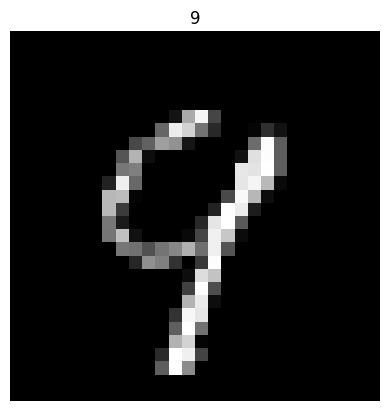

In [236]:
random_idx = np.random.randint(1000)

image = x_test[random_idx]
label = y_test[random_idx]


visualize_image(image, label)
input_layer = image.flatten()

In [238]:
_, new_output = forward_pass(input_layer, weights)
norm_new_output = np.array(tf.nn.softmax(new_output)) # transforming the logits to probs
np.argmax(norm_new_output)

7

In [55]:
new_output

array([ 0.50433666, -0.00832172, -0.35964987,  1.45268183,  0.36296841,
       -0.09697751,  0.24515608,  0.68653464, -0.15607574, -0.07038648])

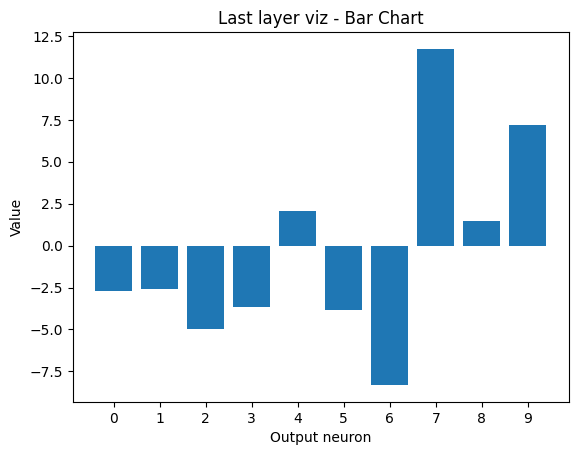

In [239]:
import matplotlib.pyplot as plt

x_indices = range(10)

plt.bar(x_indices, new_output)
plt.xlabel('Output neuron')
plt.ylabel('Value')
plt.title('Last layer viz - Bar Chart')

# Customize x-axis tick labels
plt.xticks(x_indices, x_indices)

plt.show()


In [57]:
import pickle
import os

root = os.getcwd()

with open(os.path.join(root  ,'new_trained_weights.pkl'), 'wb') as file:
    pickle.dump(weights, file)

In [58]:
with open(os.path.join(root  ,'trained_weights.pkl'), 'rb') as file:
    var = pickle.load(file)